In [8]:
from __future__ import annotations
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.distributions.normal import Normal
import pickle

import gymnasium as gym

plt.rcParams["figure.figsize"] = (10, 5)

In [9]:
class Policy_Network(nn.Module):
    """Parametrized Policy Network."""

    def __init__(self, obs_space_dims: int, action_space_dims: int):
        super().__init__()

        hidden_space1 = 32
        hidden_space2 = 32

        # Shared Network
        self.shared_net = nn.Sequential(
            nn.Linear(obs_space_dims, hidden_space1),
            nn.Tanh(),
            nn.Linear(hidden_space1, hidden_space2),
            nn.Tanh(),
        )

        # Policy Mean specific Linear Layer
        self.policy_mean_net = nn.Sequential(
            nn.Linear(hidden_space2, action_space_dims),
            nn.Tanh(),
        )

        # Policy Std Dev specific Linear Layer
        self.policy_stddev_net = nn.Sequential(
            nn.Linear(hidden_space2, action_space_dims)
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """Conditioned on the observation, returns the mean and standard deviation
         of a normal distribution from which an action is sampled from.

        Args:
            x: Observation from the environment

        Returns:
            action_means: predicted mean of the normal distribution
            action_stddevs: predicted standard deviation of the normal distribution
        """
        shared_features = self.shared_net(x.float())

        action_means = self.policy_mean_net(shared_features)
        action_stddevs = torch.log(
            1 + torch.exp(self.policy_stddev_net(shared_features))
        )
        return action_means, action_stddevs

In [10]:
class REINFORCE:
    def __init__(self, obs_space_dims: int, action_space_dims: int, nn_file_path: str = None):
        # Hyperparameters
        self.learning_rate = 1e-4  # Learning rate for policy optimization
        self.gamma = 0.99  # Discount factor
        self.eps = 1e-6 

        self.probs = []  # Stores probability values of the sampled action
        self.rewards = []  # Stores the corresponding rewards
        if nn_file_path == None:
            self.net = Policy_Network(obs_space_dims, action_space_dims)
        else:
            with open(nn_file_path, 'rb') as file:
                self.net = pickle.load(file)
        self.optimizer = torch.optim.AdamW(self.net.parameters(), lr=self.learning_rate)

    def sample_action(self, state: np.ndarray) -> float:
        state = torch.tensor(np.array([state]))
        action_means, action_stddevs = self.net(state)

        # create a normal distribution from the predicted
        #   mean and standard deviation and sample an action
        distrib = Normal(action_means[0] + self.eps, action_stddevs[0] + self.eps)
        action = distrib.sample()
        prob = distrib.log_prob(action)

        action = action.numpy()

        self.probs.append(prob)

        return action

    def update(self):
        """Updates the policy network's weights."""
        running_g = 0
        gs = []

        # Discounted return (backwards) - [::-1] will return an array in reverse
        for R in self.rewards[::-1]:
            running_g = R + self.gamma * running_g
            gs.insert(0, running_g)

        deltas = torch.tensor(gs)

        loss = 0
        # minimize -1 * prob * reward obtained
        for log_prob, delta in zip(self.probs, deltas):
            loss += log_prob.mean() * delta * (-1)

        # Update the policy network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Empty / zero out all episode-centric/related variables
        self.probs = []
        self.rewards = []
    def save(self, nn_file_path: str):
        with open(nn_file_path, 'wb') as file:
            pickle.dump(self.net, file)


In [11]:
# env = gym.make("InvertedPendulum-v4", render_mode = 'rgb_array')
from segway_sim.envs import SegwayEnv
env = SegwayEnv(max_ep_len = 1000)
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward
# wrapped_env = gym.wrappers.RecordVideo(wrapped_env, 'videos', episode_trigger = lambda x: x % 1000 == 0)

obs_space_dims = env.observation_space.shape[0]
action_space_dims = env.action_space.shape[0]
print('ob space:', obs_space_dims)
print('ac space:', action_space_dims)

seed = 1
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

agent = REINFORCE(obs_space_dims, action_space_dims, nn_file_path='nn_segway.pkl')
agent.learning_rate = 1e-4
reward_over_episodes = []

for episode in range(100000):
    obs, info = wrapped_env.reset(seed=seed)
    done = False
    while not done:
        action = agent.sample_action(obs)
        obs, reward, terminated, truncated, info = wrapped_env.step(action)
        agent.rewards.append(reward)
        done = terminated or truncated

    reward_over_episodes.append(wrapped_env.return_queue[-1])
    agent.update()

    if episode % 1000 == 0:
        avg_reward = int(np.mean(wrapped_env.return_queue))
        print("Episode:", episode, "Average Reward:", avg_reward)
agent.save('nn_segway.pkl')

ob space: 6
ac space: 1
Episode: 0 Average Reward: 98
Episode: 1000 Average Reward: 242
Episode: 2000 Average Reward: 244
Episode: 3000 Average Reward: 281


KeyboardInterrupt: 

In [12]:
agent.save('nn_segway.pkl')

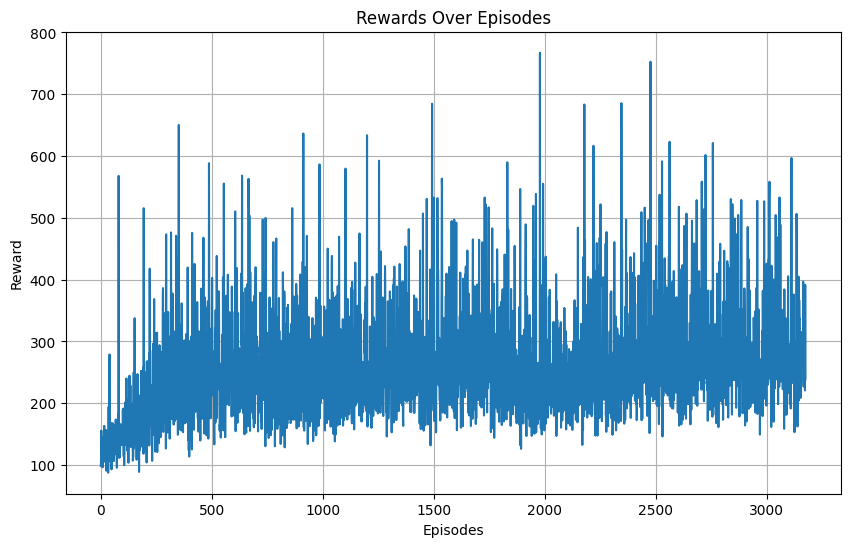

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(reward_over_episodes)
plt.title("Rewards Over Episodes")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

In [15]:
from gymnasium.wrappers import RecordVideo
# env = gym.make("InvertedPendulum-v4", render_mode = 'rgb_array')
env = SegwayEnv(max_ep_len = 1000, render_mode="rgb_array")
video_env = RecordVideo(env, video_folder="videos", name_prefix="Segway")
observation, info = video_env.reset(seed=seed)
print(video_env.action_space)
for i in range(1000):
    action = agent.sample_action(observation)
    # print(action)
    # action = env.action_space.sample()
    observation, reward, terminated, truncated, info = video_env.step(action)
    if terminated or truncated:
        print("terminated at", i)
        break
        observation, info = video_env.reset()
video_env.close()

/Users/robertli/miniconda3/envs/mujoco_sim/lib/python3.9/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/robertli/github/tinySegway/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Box(-1.0, 1.0, (1,), float32)
[0.09969272]
[1.1140189]
[0.88845456]
[-0.5015869]
[0.75507087]
[1.2304522]
[-0.30557942]
[-0.6136354]
[-0.97568524]
[-1.1518872]
[0.0492906]
[0.19653918]
[0.46821514]
[1.1462839]
[1.0681623]
[0.7776338]
[0.27484116]
[-0.7263948]
[-0.937544]
[0.13790292]
[1.5748456]
[0.93199134]
[0.7348822]
[-0.65285987]
[-0.9777803]
[-0.7492849]
[-0.5878989]
[-0.20819429]
[-0.01440457]
[-0.67436093]
[0.88917536]
[0.19035146]
[-0.10287413]
[-0.23048523]
[1.0174459]
[-0.60334265]
[-0.5798491]
[-0.76523924]
[-0.1486429]
[-0.001176]
[-0.13795254]
[0.757189]
[-0.67377394]
[-0.03839508]
[0.61408985]
[1.0373954]
[1.3735712]
[-0.018332]
[-0.12173256]
[-0.39501]
[0.53651845]
[0.7114775]
[0.59052694]
[0.39241028]
[0.10950106]
[-0.98416936]
[-1.6235352]
[-0.42146522]
[-0.19346079]
[0.4625611]
[0.5626366]
[0.87805104]
[-0.42147025]
[-0.6157335]
[0.04146755]
[0.20846987]
[0.00541032]
[-1.0695087]
[-0.70742524]
[-0.90691185]
[-0.9681288]
[0.15969583]
[0.20085034]
[0.77457494]
[1.530794

Moviepy - Done !
Moviepy - video ready /Users/robertli/github/tinySegway/videos/Segway-episode-0.mp4
terminated at 246
